In [392]:
import numpy as np
import math
import scipy
import pandas as pd
import matplotlib.pyplot as plt

In [393]:
# product j in cluster g market share calculation:

def mkt_share_cal_nest_g(data, gn, params ):
    
    alpha_list = params['alpha']
    gamma = params['gamma']
    eps_g = params['eps_g']
    sigma_g = params['sigma_g']
    
    I_sum = 0
    for g in range(gn):

        p_g = np.array(data.loc[data['cluster'] == g, 'price'])
        b_g = np.array(data.loc[data['cluster'] == g, 'prod_att'])
        #sigma_g = data.loc[data['cluster'] == g, 'sigma'].iloc[0]

        utility_g = ( ( alpha_list[g] * p_g + gamma*b_g + eps_g ) / ( 1 - sigma_g[g]) )
        exp_util_g = np.exp( utility_g )

        I_g = ( 1 - sigma_g[g]) * np.log( np.sum(exp_util_g) )
        I_sum = I_sum + np.exp( I_g )
        
    I = np.log( 1 + I_sum )
        
    #mkt_share = np.array()
    for g in range(gn):
        
        p_g = np.array(data.loc[data['cluster'] == g, 'price'])
        b_g = np.array(data.loc[data['cluster'] == g, 'prod_att'])
        #sigma_g = data.loc[data['cluster'] == g, 'sigma'].iloc[0]
        
        utility_g = ( ( alpha_list[g]*p_g + gamma*b_g + eps_g ) / ( 1 - sigma_g[g]) )
        exp_util_g = np.exp( utility_g )

        I_g = ( 1 - sigma_g[g]) * np.log( np.sum(exp_util_g) )
        mkt_share_g = ( exp_util_g / np.exp( I_g / (1 - sigma_g[g]) ) ) * ( np.exp( I_g ) / np.exp( I ) )
        
        if g == 0:
            mkt_share = mkt_share_g
        else:
            mkt_share = np.append(mkt_share, mkt_share_g)
    
    return mkt_share
        

In [394]:
def market_simulator(params):
    
    # simulate one market
    cov1 = np.array([[0.16, 0.16, 0.2], [0.16, 0.25, 0], [0.2, 0, 1]])
    pts1 = np.random.multivariate_normal([0.8, 0.5, 2], cov1, size=50)

    sig_val = 0.1
    pts1 = np.append( np.append( pts1, np.array([[0]] * 50), axis=1 ), np.array([[sig_val]] * 50), axis=1 )

    cov2 = np.array([[0.16, 0.16, 0.2], [0.16, 0.25, 0], [0.2, 0, 1]])
    pts2 = np.random.multivariate_normal([0.8, 0.5, 2], cov2, size=50)

    sig_val = 0.2
    pts2 = np.append( np.append( pts2, np.array([[1]] * 50), axis=1 ), np.array([[sig_val]] * 50), axis=1 )

    arr_2 = np.append(pts1, pts2, axis=0)

    for g in range(3, 10):

        cov = np.array([[0.16, 0.16, 0.2], [0.16, 0.25, 0], [0.2, 0, 1]])
        pts = np.random.multivariate_normal([0.8, 0.5, 2], cov, size=50)

        sig_val = 0.1 * g
        pts = np.append( np.append( pts, np.array([[g-1]] * 50), axis=1 ), np.array([[sig_val]] * 50), axis=1 )
        arr_2 = np.append(arr_2, pts, axis=0)


    data = pd.DataFrame(arr_2, columns=['price', 'prod_att', 'price_instrument', 'cluster', 'sigma'])

    data_2 = data.sample(frac=0.8).sort_values('cluster').reset_index(drop=True)
    
    #data_2['sigma'] = 0.7
    
    share_vals = mkt_share_cal_nest_g(data_2, 9, params)
    data_2['market_share'] = share_vals.tolist()
    
    shock = np.exp( np.random.normal(0, 0.01, data_2.shape[0]) )
    data_2['shock'] = shock.tolist()
    data_2['market_share'] = data_2['market_share'] * data_2['shock']
    
    return data_2



In [395]:
#params = {'alpha': -1, 'gamma': 0.8, 'eps_g': 0.0, 'sigma_g': 0.7}
price_coef_list = [(8-x) * -0.15 - 0.8 for x in range(9)]
sigma_g_list = [(x + 1) * 0.1 for x in range(9)]
params = {'alpha': price_coef_list, 'gamma': 0.8, 'eps_g': 0.0, 'sigma_g': sigma_g_list}


num_markets = 80

main_data = pd.DataFrame([])
for m in range(num_markets):
    one_market_data = market_simulator(params)
    one_market_data['market_id'] = m
    main_data = pd.concat([main_data, one_market_data])
    main_data.reset_index(drop=True, inplace=True)
    
#main_data.tail(50)

In [396]:
main_data.loc[main_data['market_id'] == 2, 'market_share'].sum()

0.9769254891896819

In [397]:
nest_size_data = main_data.groupby(['cluster', 'market_id']).agg({'prod_att': 'count', 'market_share': 'sum'}).reset_index().rename(columns={'prod_att': 'nest_size', 'market_share': 'cluster_market_share'})

main_data = main_data.merge(nest_size_data, on=['cluster', 'market_id'], how='inner')
#main_data.head(50)

In [398]:
total_mkt_share_data = main_data.groupby(['market_id']).agg({'market_share': 'sum'}).reset_index().rename(columns={'market_share': 'total_market_share'})
total_mkt_share_data['outside_good_share'] = 1 - total_mkt_share_data['total_market_share']

main_data = main_data.merge(total_mkt_share_data, on=['market_id'], how='inner')

main_data.head()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419


In [399]:
main_data.head(5)

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419


In [400]:
main_data[['price', 'prod_att', 'price_instrument']].cov()

,price,prod_att,price_instrument
price,0.159909,0.160541,0.197855
prod_att,0.160541,0.251267,-0.001598
price_instrument,0.197855,-0.001598,0.997993


In [401]:
main_data[['price', 'prod_att', 'price_instrument']].corr()

,price,prod_att,price_instrument
price,1.000000,0.800906,0.495276
prod_att,0.800906,1.000000,-0.003192
price_instrument,0.495276,-0.003192,1.000000


In [402]:
np.array([[0.16, 0.16, 0.2], [0.16, 0.25, 0], [0.2, 0, 1]])

array([[0.16, 0.16, 0.2 ],
       [0.16, 0.25, 0.  ],
       [0.2 , 0.  , 1.  ]])

In [403]:
import statsmodels.formula.api as smf

In [404]:
main_data['log_market_share'] = np.log(main_data['market_share'])
main_data['prod_cluster_cond_market_share'] = main_data['market_share'] / main_data['cluster_market_share']

main_data['log_prod_cluster_cond_market_share'] = np.log(main_data['prod_cluster_cond_market_share'])

main_data['log_outside_good_share'] = np.log(main_data['outside_good_share'])
main_data['log_market_share_minus_log_outside_share'] = main_data['log_market_share'] - main_data['log_outside_good_share']

main_data.columns

Index(['price', 'prod_att', 'price_instrument', 'cluster', 'sigma',
       'market_share', 'shock', 'market_id', 'nest_size',
       'cluster_market_share', 'total_market_share', 'outside_good_share',
       'log_market_share', 'prod_cluster_cond_market_share',
       'log_prod_cluster_cond_market_share', 'log_outside_good_share',
       'log_market_share_minus_log_outside_share'],
      dtype='object')

In [405]:
main_data['intercept'] = 1
main_data.head()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,log_market_share,prod_cluster_cond_market_share,log_prod_cluster_cond_market_share,log_outside_good_share,log_market_share_minus_log_outside_share,intercept
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419,-5.349702,0.019174,-3.954181,-3.721819,-1.627883,1
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419,-5.831781,0.011840,-4.436261,-3.721819,-2.109962,1
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419,-4.493096,0.045159,-3.097576,-3.721819,-0.771277,1
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419,-4.999122,0.027225,-3.603602,-3.721819,-1.277303,1
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419,-4.617610,0.039872,-3.222090,-3.721819,-0.895791,1


In [406]:
main_data['cluster_0'] = 0
main_data.loc[ main_data['cluster'] == 0, 'cluster_0' ] = 1

main_data['cluster_1'] = 0
main_data.loc[ main_data['cluster'] == 1, 'cluster_1' ] = 1

main_data['cluster_2'] = 0
main_data.loc[ main_data['cluster'] == 2, 'cluster_2' ] = 1

main_data['cluster_3'] = 0
main_data.loc[ main_data['cluster'] == 3, 'cluster_3' ] = 1

main_data['cluster_4'] = 0
main_data.loc[ main_data['cluster'] == 4, 'cluster_4' ] = 1

main_data['cluster_5'] = 0
main_data.loc[ main_data['cluster'] == 5, 'cluster_5' ] = 1

main_data['cluster_6'] = 0
main_data.loc[ main_data['cluster'] == 6, 'cluster_6' ] = 1

main_data['cluster_7'] = 0
main_data.loc[ main_data['cluster'] == 7, 'cluster_7' ] = 1

main_data['cluster_8'] = 0
main_data.loc[ main_data['cluster'] == 8, 'cluster_8' ] = 1

main_data.head()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,log_market_share,prod_cluster_cond_market_share,log_prod_cluster_cond_market_share,log_outside_good_share,log_market_share_minus_log_outside_share,intercept,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419,-5.349702,0.019174,-3.954181,-3.721819,-1.627883,1,1,0,0,0,0,0,0,0,0
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419,-5.831781,0.011840,-4.436261,-3.721819,-2.109962,1,1,0,0,0,0,0,0,0,0
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419,-4.493096,0.045159,-3.097576,-3.721819,-0.771277,1,1,0,0,0,0,0,0,0,0
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419,-4.999122,0.027225,-3.603602,-3.721819,-1.277303,1,1,0,0,0,0,0,0,0,0
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419,-4.617610,0.039872,-3.222090,-3.721819,-0.895791,1,1,0,0,0,0,0,0,0,0


In [407]:
main_data.columns

Index(['price', 'prod_att', 'price_instrument', 'cluster', 'sigma',
       'market_share', 'shock', 'market_id', 'nest_size',
       'cluster_market_share', 'total_market_share', 'outside_good_share',
       'log_market_share', 'prod_cluster_cond_market_share',
       'log_prod_cluster_cond_market_share', 'log_outside_good_share',
       'log_market_share_minus_log_outside_share', 'intercept', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8'],
      dtype='object')

In [408]:
main_data['log_prod_cluster_cond_market_share_c_0'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_0']
main_data['log_prod_cluster_cond_market_share_c_1'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_1']
main_data['log_prod_cluster_cond_market_share_c_2'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_2']
main_data['log_prod_cluster_cond_market_share_c_3'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_3']
main_data['log_prod_cluster_cond_market_share_c_4'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_4']
main_data['log_prod_cluster_cond_market_share_c_5'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_5']
main_data['log_prod_cluster_cond_market_share_c_6'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_6']
main_data['log_prod_cluster_cond_market_share_c_7'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_7']
main_data['log_prod_cluster_cond_market_share_c_8'] = main_data['log_prod_cluster_cond_market_share'] * main_data['cluster_8']

main_data['nest_size_c_0'] = main_data['nest_size'] * main_data['cluster_0']
main_data['nest_size_c_1'] = main_data['nest_size'] * main_data['cluster_1']
main_data['nest_size_c_2'] = main_data['nest_size'] * main_data['cluster_2']
main_data['nest_size_c_3'] = main_data['nest_size'] * main_data['cluster_3']
main_data['nest_size_c_4'] = main_data['nest_size'] * main_data['cluster_4']
main_data['nest_size_c_5'] = main_data['nest_size'] * main_data['cluster_5']
main_data['nest_size_c_6'] = main_data['nest_size'] * main_data['cluster_6']
main_data['nest_size_c_7'] = main_data['nest_size'] * main_data['cluster_7']
main_data['nest_size_c_8'] = main_data['nest_size'] * main_data['cluster_8']

main_data['price_inst_c_0'] = main_data['price_instrument'] * main_data['cluster_0']
main_data['price_inst_c_1'] = main_data['price_instrument'] * main_data['cluster_1']
main_data['price_inst_c_2'] = main_data['price_instrument'] * main_data['cluster_2']
main_data['price_inst_c_3'] = main_data['price_instrument'] * main_data['cluster_3']
main_data['price_inst_c_4'] = main_data['price_instrument'] * main_data['cluster_4']
main_data['price_inst_c_5'] = main_data['price_instrument'] * main_data['cluster_5']
main_data['price_inst_c_6'] = main_data['price_instrument'] * main_data['cluster_6']
main_data['price_inst_c_7'] = main_data['price_instrument'] * main_data['cluster_7']
main_data['price_inst_c_8'] = main_data['price_instrument'] * main_data['cluster_8']

main_data['price_c_0'] = main_data['price'] * main_data['cluster_0']
main_data['price_c_1'] = main_data['price'] * main_data['cluster_1']
main_data['price_c_2'] = main_data['price'] * main_data['cluster_2']
main_data['price_c_3'] = main_data['price'] * main_data['cluster_3']
main_data['price_c_4'] = main_data['price'] * main_data['cluster_4']
main_data['price_c_5'] = main_data['price'] * main_data['cluster_5']
main_data['price_c_6'] = main_data['price'] * main_data['cluster_6']
main_data['price_c_7'] = main_data['price'] * main_data['cluster_7']
main_data['price_c_8'] = main_data['price'] * main_data['cluster_8']

main_data.columns

Index(['price', 'prod_att', 'price_instrument', 'cluster', 'sigma',
       'market_share', 'shock', 'market_id', 'nest_size',
       'cluster_market_share', 'total_market_share', 'outside_good_share',
       'log_market_share', 'prod_cluster_cond_market_share',
       'log_prod_cluster_cond_market_share', 'log_outside_good_share',
       'log_market_share_minus_log_outside_share', 'intercept', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8',
       'log_prod_cluster_cond_market_share_c_0',
       'log_prod_cluster_cond_market_share_c_1',
       'log_prod_cluster_cond_market_share_c_2',
       'log_prod_cluster_cond_market_share_c_3',
       'log_prod_cluster_cond_market_share_c_4',
       'log_prod_cluster_cond_market_share_c_5',
       'log_prod_cluster_cond_market_share_c_6',
       'log_prod_cluster_cond_market_share_c_7',
       'log_prod_cluster_cond_market_share_c_8', 'nest_size_c_0',
       'nest_s

In [409]:
import statsmodels.sandbox.regression.gmm as sm

exog_list = ['price_c_0', 'price_c_1', 'price_c_2', 'price_c_3', 'price_c_4',
       'price_c_5', 'price_c_6', 'price_c_7', 'price_c_8', 'prod_att', 'log_prod_cluster_cond_market_share_c_0',
       'log_prod_cluster_cond_market_share_c_1',
       'log_prod_cluster_cond_market_share_c_2',
       'log_prod_cluster_cond_market_share_c_3',
       'log_prod_cluster_cond_market_share_c_4',
       'log_prod_cluster_cond_market_share_c_5',
       'log_prod_cluster_cond_market_share_c_6',
       'log_prod_cluster_cond_market_share_c_7',
       'log_prod_cluster_cond_market_share_c_8']

instrument_list = ['price_inst_c_0',
       'price_inst_c_1', 'price_inst_c_2', 'price_inst_c_3', 'price_inst_c_4',
       'price_inst_c_5', 'price_inst_c_6', 'price_inst_c_7', 'price_inst_c_8', 'prod_att', 'nest_size_c_0',
       'nest_size_c_1', 'nest_size_c_2', 'nest_size_c_3', 'nest_size_c_4',
       'nest_size_c_5', 'nest_size_c_6', 'nest_size_c_7', 'nest_size_c_8']

In [410]:
IV_estimation = sm.IV2SLS(endog=main_data['log_market_share_minus_log_outside_share'], exog=main_data[['intercept'] + exog_list], instrument=main_data[['intercept'] + instrument_list]).fit()

#IV_estimation
print(IV_estimation.params)

intercept                                 0.007230
price_c_0                                -1.995677
price_c_1                                -1.833877
price_c_2                                -1.699440
price_c_3                                -1.547397
price_c_4                                -1.409552
price_c_5                                -1.261298
price_c_6                                -1.074192
price_c_7                                -0.922047
price_c_8                                -0.710536
prod_att                                  0.785315
log_prod_cluster_cond_market_share_c_0    0.100877
log_prod_cluster_cond_market_share_c_1    0.203493
log_prod_cluster_cond_market_share_c_2    0.300332
log_prod_cluster_cond_market_share_c_3    0.400620
log_prod_cluster_cond_market_share_c_4    0.498031
log_prod_cluster_cond_market_share_c_5    0.597952
log_prod_cluster_cond_market_share_c_6    0.705396
log_prod_cluster_cond_market_share_c_7    0.805317
log_prod_cluster_cond_market_sh

In [411]:
IV_estimation = sm.IV2SLS(endog=main_data['log_market_share_minus_log_outside_share'], exog=main_data[exog_list], instrument=main_data[instrument_list]).fit()

#IV_estimation
print(IV_estimation.params)

price_c_0                                -1.994355
price_c_1                                -1.828162
price_c_2                                -1.697325
price_c_3                                -1.544878
price_c_4                                -1.404510
price_c_5                                -1.253628
price_c_6                                -1.057673
price_c_7                                -0.893963
price_c_8                                -0.953769
prod_att                                  0.805917
log_prod_cluster_cond_market_share_c_0    0.102048
log_prod_cluster_cond_market_share_c_1    0.205499
log_prod_cluster_cond_market_share_c_2    0.301491
log_prod_cluster_cond_market_share_c_3    0.401973
log_prod_cluster_cond_market_share_c_4    0.499843
log_prod_cluster_cond_market_share_c_5    0.600188
log_prod_cluster_cond_market_share_c_6    0.709494
log_prod_cluster_cond_market_share_c_7    0.811091
log_prod_cluster_cond_market_share_c_8    0.880582
dtype: float64


In [412]:
params

{'alpha': [-2.0,
  -1.85,
  -1.7,
  -1.55,
  -1.4,
  -1.25,
  -1.1,
  -0.9500000000000001,
  -0.8],
 'gamma': 0.8,
 'eps_g': 0.0,
 'sigma_g': [0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9]}

In [413]:
from linearmodels import IV2SLS 

IV2SLS(main_data["log_market_share_minus_log_outside_share"], main_data["intercept"], main_data[exog_list], main_data[instrument_list]).fit()



C:\Users\Tsenguunn\anaconda3\lib\site-packages\linearmodels\shared\linalg.py:64: RuntimeWarning: invalid value encountered in sqrt
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T


IV-2SLS Estimation Summary                                     
====================================================================================================
Dep. Variable:     log_market_share_minus_log_outside_share   R-squared:                      0.9995
Estimator:                                          IV-2SLS   Adj. R-squared:                 0.9995
No. Observations:                                     28800   F-statistic:                 3.449e+07
Date:                                      Wed, Jan 03 2024   P-value (F-stat)                0.0000
Time:                                              10:08:37   Distribution:                 chi2(19)
Cov. Estimator:                                      robust                                         
                                                                                                    
                                           Parameter Estimates                                            
==========================================================================================================
                                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------------
intercept                                  0.0072     0.0104     0.6925     0.4886     -0.0132      0.0277
price_c_0                                 -1.9957     0.0063    -318.10     0.0000     -2.0080     -1.9834
price_c_1                                 -1.8339     0.0062    -296.05     0.0000     -1.8460     -1.8217
price_c_2                                 -1.6994     0.0071    -238.96     0.0000     -1.7134     -1.6855
price_c_3                                 -1.5474     0.0073    -213.22     0.0000     -1.5616     -1.5332
price_c_4                                 -1.4096     0.0080    -176.49     0.0000     -1.4252     -1.3939
price_c_5                                 -1.2613     0.0090    -139.90     0.0000     -1.2790     -1.2436
price_c_6                                 -1.0742     0.0143    -75.120     0.0000     -1.1022     -1.0462
price_c_7                                 -0.9220     0.0250    -36.938     0.0000     -0.9710     -0.8731
price_c_8                                 -0.7105     0.1574    -4.5129     0.0000     -1.0191     -0.4019
prod_att                                   0.7853     0.0178     44.101     0.0000      0.7504      0.8202
log_prod_cluster_cond_market_share_c_0     0.1009     0.0018     56.181     0.0000      0.0974      0.1044
log_prod_cluster_cond_market_share_c_1     0.2035     0.0017     121.10     0.0000      0.2002      0.2068
log_prod_cluster_cond_market_share_c_2     0.3003     0.0020     151.72     0.0000      0.2965      0.3042
log_prod_cluster_cond_market_share_c_3     0.4006     0.0020     200.76     0.0000      0.3967      0.4045
log_prod_cluster_cond_market_share_c_4     0.4980     0.0021     234.75     0.0000      0.4939      0.5022
log_prod_cluster_cond_market_share_c_5     0.5980     0.0023     265.56     0.0000      0.5935      0.6024
log_prod_cluster_cond_market_share_c_6     0.7054     0.0033     216.03     0.0000      0.6990      0.7118
log_prod_cluster_cond_market_share_c_7     0.8053     0.0049     163.72     0.0000      0.7957      0.8150
log_prod_cluster_cond_market_share_c_8     0.9120     0.0208     43.912     0.0000      0.8713      0.9527
==========================================================================================================

Endogenous: price_c_0, price_c_1, price_c_2, price_c_3, price_c_4, price_c_5, price_c_6, price_c_7, price_c_8, prod_att, log_prod_cluster_cond_market_share_c_0, log_prod_cluster_cond_market_share_c_1, log_prod_cluster_cond_market_share_c_2, log_prod_cluster_cond_market_share_c_3, log_prod_cluster_cond_market_share_c_4, log_prod_cluster_cond_market_share_c_5, log_prod_cluster_cond_market_share_c_6, log_prod_cluster_cond_market_share_c_7, log_prod_cl

In [414]:
params['alpha']

[-2.0, -1.85, -1.7, -1.55, -1.4, -1.25, -1.1, -0.9500000000000001, -0.8]

In [415]:
params['sigma_g']

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [416]:
IV2SLS(main_data["log_market_share_minus_log_outside_share"], None, main_data[exog_list], main_data[instrument_list]).fit()


C:\Users\Tsenguunn\anaconda3\lib\site-packages\linearmodels\shared\linalg.py:64: RuntimeWarning: invalid value encountered in sqrt
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T


IV-2SLS Estimation Summary                                     
====================================================================================================
Dep. Variable:     log_market_share_minus_log_outside_share   R-squared:                      0.9998
Estimator:                                          IV-2SLS   Adj. R-squared:                 0.9998
No. Observations:                                     28800   F-statistic:                 1.799e+08
Date:                                      Wed, Jan 03 2024   P-value (F-stat)                0.0000
Time:                                              10:08:38   Distribution:                 chi2(19)
Cov. Estimator:                                      robust                                         
                                                                                                    
                                           Parameter Estimates                                            
==========================================================================================================
                                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------------
price_c_0                                 -1.9944     0.0094    -211.19     0.0000     -2.0129     -1.9758
price_c_1                                 -1.8282     0.0142    -128.94     0.0000     -1.8560     -1.8004
price_c_2                                 -1.6973     0.0115    -147.27     0.0000     -1.7199     -1.6747
price_c_3                                 -1.5449     0.0127    -121.90     0.0000     -1.5697     -1.5200
price_c_4                                 -1.4045     0.0170    -82.826     0.0000     -1.4377     -1.3713
price_c_5                                 -1.2536     0.0223    -56.240     0.0000     -1.2973     -1.2099
price_c_6                                 -1.0577     0.0422    -25.071     0.0000     -1.1404     -0.9750
price_c_7                                 -0.8940     0.0814    -10.980     0.0000     -1.0535     -0.7344
price_c_8                                 -0.9538     0.3298    -2.8917     0.0038     -1.6002     -0.3073
prod_att                                   0.8059     0.0198     40.737     0.0000      0.7671      0.8447
log_prod_cluster_cond_market_share_c_0     0.1020     0.0045     22.854     0.0000      0.0933      0.1108
log_prod_cluster_cond_market_share_c_1     0.2055     0.0054     37.999     0.0000      0.1949      0.2161
log_prod_cluster_cond_market_share_c_2     0.3015     0.0047     64.376     0.0000      0.2923      0.3107
log_prod_cluster_cond_market_share_c_3     0.4020     0.0051     79.481     0.0000      0.3921      0.4119
log_prod_cluster_cond_market_share_c_4     0.4998     0.0059     84.901     0.0000      0.4883      0.5114
log_prod_cluster_cond_market_share_c_5     0.6002     0.0068     88.736     0.0000      0.5869      0.6134
log_prod_cluster_cond_market_share_c_6     0.7095     0.0108     65.838     0.0000      0.6884      0.7306
log_prod_cluster_cond_market_share_c_7     0.8111     0.0168     48.236     0.0000      0.7781      0.8440
log_prod_cluster_cond_market_share_c_8     0.8806     0.0417     21.104     0.0000      0.7988      0.9624
==========================================================================================================

Endogenous: price_c_0, price_c_1, price_c_2, price_c_3, price_c_4, price_c_5, price_c_6, price_c_7, price_c_8, prod_att, log_prod_cluster_cond_market_share_c_0, log_prod_cluster_cond_market_share_c_1, log_prod_cluster_cond_market_share_c_2, log_prod_cluster_cond_market_share_c_3, log_prod_cluster_cond_market_share_c_4, log_prod_cluster_cond_market_share_c_5, log_prod_cluster_cond_market_share_c_6, log_prod_cluster_cond_market_share_c_7, log_prod_cluster_cond_market_share_c_8
Instruments: price_inst_c_0, price_inst_c_1, price_inst_c_2, price_inst_c_3, pr

In [417]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#main_data.head(360)

In [418]:
params['alpha']

[-2.0, -1.85, -1.7, -1.55, -1.4, -1.25, -1.1, -0.9500000000000001, -0.8]

In [419]:
main_data.head()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,log_market_share,prod_cluster_cond_market_share,log_prod_cluster_cond_market_share,log_outside_good_share,log_market_share_minus_log_outside_share,intercept,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,log_prod_cluster_cond_market_share_c_0,log_prod_cluster_cond_market_share_c_1,log_prod_cluster_cond_market_share_c_2,log_prod_cluster_cond_market_share_c_3,log_prod_cluster_cond_market_share_c_4,log_prod_cluster_cond_market_share_c_5,log_prod_cluster_cond_market_share_c_6,log_prod_cluster_cond_market_share_c_7,log_prod_cluster_cond_market_share_c_8,nest_size_c_0,nest_size_c_1,nest_size_c_2,nest_size_c_3,nest_size_c_4,nest_size_c_5,nest_size_c_6,nest_size_c_7,nest_size_c_8,price_inst_c_0,price_inst_c_1,price_inst_c_2,price_inst_c_3,price_inst_c_4,price_inst_c_5,price_inst_c_6,price_inst_c_7,price_inst_c_8,price_c_0,price_c_1,price_c_2,price_c_3,price_c_4,price_c_5,price_c_6,price_c_7,price_c_8
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419,-5.349702,0.019174,-3.954181,-3.721819,-1.627883,1,1,0,0,0,0,0,0,0,0,-3.954181,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,40,0,0,0,0,0,0,0,0,1.809659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419,-5.831781,0.011840,-4.436261,-3.721819,-2.109962,1,1,0,0,0,0,0,0,0,0,-4.436261,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,40,0,0,0,0,0,0,0,0,3.183882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419,-4.493096,0.045159,-3.097576,-3.721819,-0.771277,1,1,0,0,0,0,0,0,0,0,-3.097576,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,40,0,0,0,0,0,0,0,0,1.478279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419,-4.999122,0.027225,-3.603602,-3.721819,-1.277303,1,1,0,0,0,0,0,0,0,0,-3.603602,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,40,0,0,0,0,0,0,0,0,2.602437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.554190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419,-4.617610,0.039872,-3.222090,-3.721819,-0.895791,1,1,0,0,0,0,0,0,0,0,-3.222090,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,40,0,0,0,0,0,0,0,0,0.867303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [420]:
main_data.columns

Index(['price', 'prod_att', 'price_instrument', 'cluster', 'sigma',
       'market_share', 'shock', 'market_id', 'nest_size',
       'cluster_market_share', 'total_market_share', 'outside_good_share',
       'log_market_share', 'prod_cluster_cond_market_share',
       'log_prod_cluster_cond_market_share', 'log_outside_good_share',
       'log_market_share_minus_log_outside_share', 'intercept', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8',
       'log_prod_cluster_cond_market_share_c_0',
       'log_prod_cluster_cond_market_share_c_1',
       'log_prod_cluster_cond_market_share_c_2',
       'log_prod_cluster_cond_market_share_c_3',
       'log_prod_cluster_cond_market_share_c_4',
       'log_prod_cluster_cond_market_share_c_5',
       'log_prod_cluster_cond_market_share_c_6',
       'log_prod_cluster_cond_market_share_c_7',
       'log_prod_cluster_cond_market_share_c_8', 'nest_size_c_0',
       'nest_s

In [421]:
market_0 = main_data.loc[ main_data['market_id'] == 0, ['price', 'prod_att', 'price_instrument', 'cluster', 'sigma',
       'market_share', 'shock', 'market_id', 'nest_size',
       'cluster_market_share', 'total_market_share', 'outside_good_share', 'prod_cluster_cond_market_share'] ]

market_0.tail()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,prod_cluster_cond_market_share
355,1.358388,0.978317,1.420476,8.0,0.9,0.000029,0.995288,0,39,0.037323,0.97581,0.02419,0.000786
356,0.607840,0.832904,0.143514,8.0,0.9,0.003708,0.994181,0,39,0.037323,0.97581,0.02419,0.099363
357,0.643039,-0.157812,3.710848,8.0,0.9,0.000001,0.984175,0,39,0.037323,0.97581,0.02419,0.000027
358,0.884325,0.316522,2.964989,8.0,0.9,0.000006,0.983913,0,39,0.037323,0.97581,0.02419,0.000173
359,0.462559,0.175633,1.372398,8.0,0.9,0.000062,1.003352,0,39,0.037323,0.97581,0.02419,0.001669


In [422]:
market_0.head()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,prod_cluster_cond_market_share
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419,0.019174
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419,0.011840
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419,0.045159
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419,0.027225
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419,0.039872


In [423]:
market_0['prod_att'].values[0]

0.19677610593514427

In [424]:
# Price elasticity: Market 0 and product 0

market_0.iloc[0]


price                              0.707089
prod_att                           0.196776
price_instrument                   1.809659
cluster                            0.000000
sigma                              0.100000
market_share                       0.004750
shock                              0.999757
market_id                          0.000000
nest_size                         40.000000
cluster_market_share               0.247704
total_market_share                 0.975810
outside_good_share                 0.024190
prod_cluster_cond_market_share     0.019174
Name: 0, dtype: float64

In [425]:
params

{'alpha': [-2.0,
  -1.85,
  -1.7,
  -1.55,
  -1.4,
  -1.25,
  -1.1,
  -0.9500000000000001,
  -0.8],
 'gamma': 0.8,
 'eps_g': 0.0,
 'sigma_g': [0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8,
  0.9]}

In [426]:
cluster_id = market_0.iloc[0]['cluster'].astype(int)

params['alpha'][cluster_id]

-2.0

In [427]:
params['sigma_g'][cluster_id]

0.1

In [428]:
def analytic_self_elas(market_data, product_id ):
    
    cluster_id = market_data.iloc[product_id]['cluster'].astype(int)

    alpha = params['alpha'][cluster_id]
    sigma = params['sigma_g'][cluster_id]
    
    s_j = market_data.iloc[product_id]['market_share']
    p_j = market_data.iloc[product_id]['price']
    s_j_g = market_data.iloc[product_id]['prod_cluster_cond_market_share']
    
    return alpha / ( 1 - sigma ) * p_j * ( 1 - sigma * s_j_g - (1 - sigma) * s_j )

In [429]:
analytic_self_elas(market_0, 0)

-1.561579252079343

In [430]:
analytic_self_elas(market_0, 10)

-0.579552940823518

In [431]:
mkt_share_cal_nest_g(market_0, 9, params)[:5]

array([0.00475072, 0.00287364, 0.01109137, 0.00671233, 0.00966055])

In [432]:
market_0.head()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,prod_cluster_cond_market_share
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419,0.019174
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419,0.011840
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419,0.045159
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419,0.027225
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419,0.039872


In [433]:
( mkt_share_cal_nest_g(market_0, 9, params) * market_0['shock'].values )[:5]

array([0.00474957, 0.00293285, 0.01118595, 0.00674387, 0.00987637])

In [434]:
market_0_copy = market_0.copy() 

price_val = market_0_copy.iloc[0]['price']

market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = price_val * 1.01
market_0_copy.head()

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,prod_cluster_cond_market_share
0,0.714160,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419,0.019174
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419,0.011840
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419,0.045159
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419,0.027225
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419,0.039872


In [435]:
mkt_share_cal_nest_g(market_0_copy, 9, params)[:5]

array([0.00467711, 0.00287392, 0.01109245, 0.00671298, 0.00966148])

In [436]:
( mkt_share_cal_nest_g(market_0_copy, 9, params) * market_0_copy['shock'].values )[:5]

array([0.00467597, 0.00293313, 0.01118704, 0.00674452, 0.00987732])

In [437]:
( mkt_share_cal_nest_g(market_0, 9, params) * market_0['shock'].values )[:5]

array([0.00474957, 0.00293285, 0.01118595, 0.00674387, 0.00987637])

In [438]:
0.00184634 / 0.00191236 - 1

-0.034522788596289544

In [439]:
mkt_share_cal_nest_g(market_0, 9, params)[:5]

array([0.00475072, 0.00287364, 0.01109137, 0.00671233, 0.00966055])

In [440]:
mkt_share_cal_nest_g(market_0_copy, 9, params)[:5]

array([0.00467711, 0.00287392, 0.01109245, 0.00671298, 0.00966148])

In [441]:
0.00187087 / 0.00193777 - 1

-0.034524221140795786

In [442]:
analytic_self_elas(market_0, 358)

-7.073495033024304

In [443]:
market_0_copy = market_0.copy() 

price_val = market_0_copy.iloc[358]['price']

market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = price_val * 1.01

mkt_share_cal_nest_g(market_0, 9, params)[-5:]

array([2.94631854e-05, 3.73019483e-03, 1.01704324e-06, 6.56190632e-06,
       6.20728833e-05])

In [444]:
mkt_share_cal_nest_g(market_0_copy, 9, params)[-5:]

array([2.94635047e-05, 3.73023526e-03, 1.01705427e-06, 6.11378458e-06,
       6.20735562e-05])

In [445]:
4.28607867 / 4.45832358 - 1

-0.03863445685564171

In [446]:
analytic_self_elas(market_0, 10)

-0.579552940823518

In [447]:
market_0_copy = market_0.copy() 

price_val = market_0_copy.iloc[10]['price']

market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = price_val * 1.01

mkt_share_cal_nest_g(market_0, 9, params)[:11]



array([0.00475072, 0.00287364, 0.01109137, 0.00671233, 0.00966055,
       0.0048699 , 0.00310617, 0.00182523, 0.00322167, 0.00439543,
       0.01021498])

In [448]:
mkt_share_cal_nest_g(market_0_copy, 9, params)[:11]

array([0.00475109, 0.00287386, 0.01109224, 0.00671286, 0.0096613 ,
       0.00487028, 0.00310642, 0.00182538, 0.00322192, 0.00439577,
       0.01015595])

In [449]:
0.01177759 / 0.01180701 - 1

-0.0024917400764461473

In [450]:
market_0_copy = market_0.copy() 

price_val = market_0_copy.iloc[358]['price']

market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = price_val * 1.01

mkt_share_cal_nest_g(market_0, 9, params)[-2]

6.5619063210881255e-06

In [451]:

mkt_share_cal_nest_g(market_0_copy, 9, params)[-2]

6.1137845756107144e-06

In [452]:
mkt_share_cal_nest_g(market_0_copy, 9, params)[-2] / mkt_share_cal_nest_g(market_0, 9, params)[-2] - 1

-0.06829139636408299

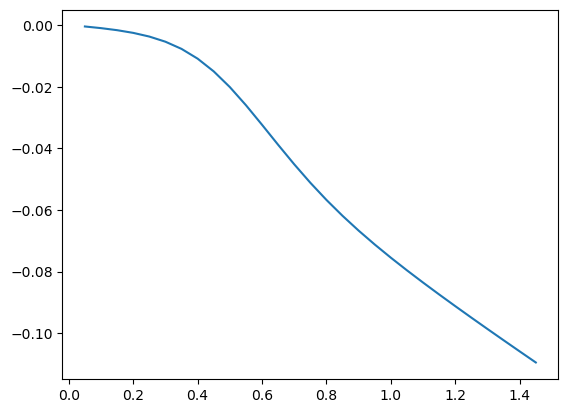

In [504]:
p_list = [0.05 * k for k in range(1, 30)]
tmp_list =[]

for p in p_list: 
    
    p_id = 344
    market_0_copy = market_0.copy() 
    price_val = market_0_copy.iloc[p_id]['price']
    market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = p
    
    market_0_copy_2 = market_0_copy.copy() 
    market_0_copy_2.loc[market_0_copy_2['price'] == p, 'price'] = p * 1.01
    
    vall = mkt_share_cal_nest_g(market_0_copy_2, 9, params)[p_id] / mkt_share_cal_nest_g(market_0_copy, 9, params)[p_id] - 1
    
    tmp_list.append( vall )
    
plt.plot(p_list, tmp_list)

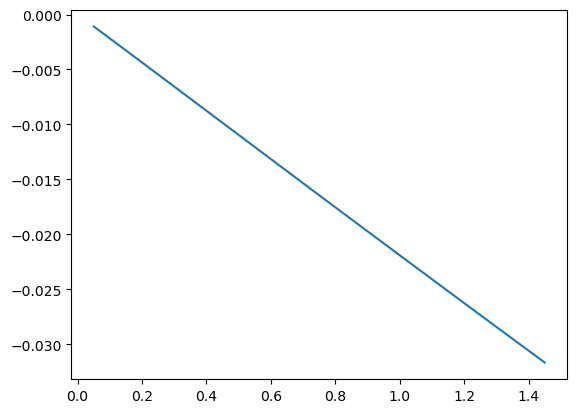

In [494]:
p_list = [0.05 * k for k in range(1, 30)]
tmp_list =[]

for p in p_list: 
    
    p_id = 20
    market_0_copy = market_0.copy() 
    price_val = market_0_copy.iloc[p_id]['price']
    market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = p
    
    market_0_copy_2 = market_0_copy.copy() 
    market_0_copy_2.loc[market_0_copy_2['price'] == p, 'price'] = p * 1.01
    
    vall = mkt_share_cal_nest_g(market_0_copy_2, 9, params)[p_id] / mkt_share_cal_nest_g(market_0_copy, 9, params)[p_id] - 1
    
    tmp_list.append( vall )
    
plt.plot(p_list, tmp_list)

In [456]:
market_0['price'].describe()

count    360.000000
mean       0.818938
std        0.393577
min       -0.453324
25%        0.537922
50%        0.810466
75%        1.106330
max        1.869314
Name: price, dtype: float64

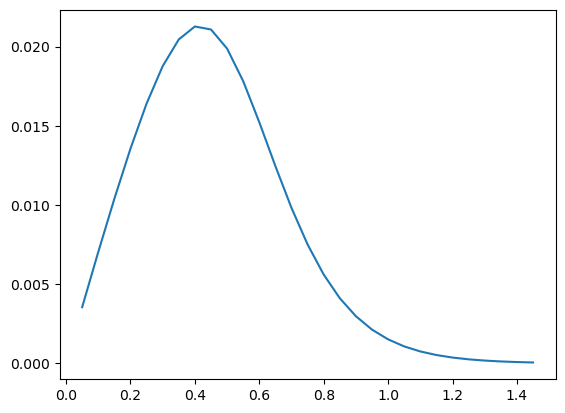

In [506]:
p_list = [0.05 * k for k in range(1, 30)]
tmp_list =[]

for p in p_list: 
    
    p_id = 344
    market_0_copy = market_0.copy() 
    price_val = market_0_copy.iloc[p_id]['price']
    market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = p
    
    market_0_copy_2 = market_0_copy.copy() 
    market_0_copy_2.loc[market_0_copy_2['price'] == p, 'price'] = p * 1.01
    
    vall = mkt_share_cal_nest_g(market_0_copy_2, 9, params)[345] / mkt_share_cal_nest_g(market_0_copy, 9, params)[345] - 1
    
    tmp_list.append( vall )
    
plt.plot(p_list, tmp_list)

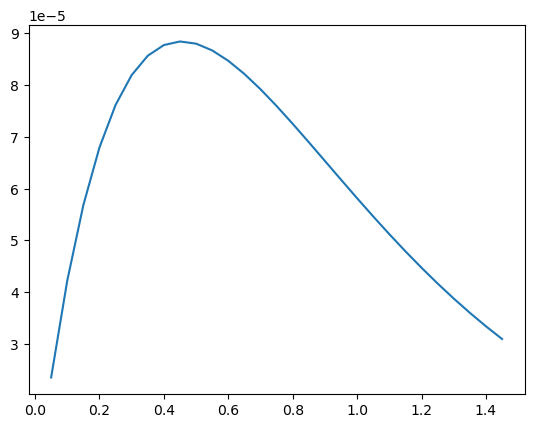

In [509]:
p_list = [0.05 * k for k in range(1, 30)]
tmp_list =[]

for p in p_list: 
    
    p_id = 10
    market_0_copy = market_0.copy() 
    price_val = market_0_copy.iloc[p_id]['price']
    market_0_copy.loc[market_0_copy['price'] == price_val, 'price'] = p
    
    market_0_copy_2 = market_0_copy.copy() 
    market_0_copy_2.loc[market_0_copy_2['price'] == p, 'price'] = p * 1.01
    
    vall = mkt_share_cal_nest_g(market_0_copy_2, 9, params)[19] / mkt_share_cal_nest_g(market_0_copy, 9, params)[19] - 1
    
    tmp_list.append( vall )
    
plt.plot(p_list, tmp_list)

In [508]:
market_0.head(100)

,price,prod_att,price_instrument,cluster,sigma,market_share,shock,market_id,nest_size,cluster_market_share,total_market_share,outside_good_share,prod_cluster_cond_market_share
0,0.707089,0.196776,1.809659,0.0,0.1,0.004750,0.999757,0,40,0.247704,0.97581,0.02419,0.019174
1,1.333484,1.197206,3.183882,0.0,0.1,0.002933,1.020605,0,40,0.247704,0.97581,0.02419,0.011840
2,0.170996,-0.189601,1.478279,0.0,0.1,0.011186,1.008527,0,40,0.247704,0.97581,0.02419,0.045159
3,0.554190,0.203384,2.602437,0.0,0.1,0.006744,1.004697,0,40,0.247704,0.97581,0.02419,0.027225
4,0.324269,0.038200,0.867303,0.0,0.1,0.009876,1.022340,0,40,0.247704,0.97581,0.02419,0.039872
5,0.573706,-0.108806,3.041348,0.0,0.1,0.004978,1.022204,0,40,0.247704,0.97581,0.02419,0.020097
6,1.062120,0.606336,3.121720,0.0,0.1,0.003102,0.998511,0,40,0.247704,0.97581,0.02419,0.012521
7,1.584292,1.313623,2.867366,0.0,0.1,0.001843,1.009963,0,40,0.247704,0.97581,0.02419,0.007442
8,1.283206,1.200123,2.650938,0.0,0.1,0.003230,1.002531,0,40,0.247704,0.97581,0.02419,0.013039
9,0.853249,0.474728,2.816230,0.0,0.1,0.004479,1.018971,0,40,0.247704,0.97581,0.02419,0.018081
